In [20]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import itertools
import glob
import matplotlib as mpl
import upsetplot

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

sr_ab = '../'+config['sr']['ab']


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
m_major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
m_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]


m_ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
m_ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]


orth_table = '../../proc_revisions/ref/biomart_human_to_mouse.tsv'
mouse_ver = 'vM25_cerberus'

## get the number of DU TSS w/ predominant TSS switching between in each tissue

In [93]:
def get_tc_mouse_samples(config, times=None):
    m_lib_meta = expand(config['lr']['meta'], species='mouse')[0]
    temp = pd.read_csv('../../proc_revisions/'+m_lib_meta, sep='\t')
    tc_tissues = ['muscle', 'hippocampus', 'cortex', 'adrenal gland', 'heart']
    tc_times = ['18-20mo', '2mo', '4d', '25d', '14d', '36d', '10d']
    if times:
        tc_times = [t for t in tc_times if t in times]
    s = temp.loc[(temp.general_tissue_cell_type.isin(tc_tissues))&\
             (temp.age.isin(tc_times)), 'sample'].unique().tolist()
    return s

In [94]:
df = pd.read_csv('filt_tc_du.tsv', sep='\t')

In [95]:
tissue = 'cortex'
feat = 'tss'
# timepts = ['14d', '2mo']
m_tss_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['tss'], species='mouse', obs_col='sample')[0]
df2 = pd.read_csv(m_tss_pi_tpm_table, sep='\t')

# limit to tc samples
print(len(df2))
df2 = df2.loc[df2['sample'].isin(get_tc_mouse_samples(config))]
df2[['tissue', 'age']] = df2['sample'].str.split('_', expand=True)

# limit to predom
df2 = df2.loc[df2.tss_rank==1]

# # get number of unique predom tss / gene / tissue
# df3 = df2[['tss_id', 'gname', 'gid', 'tissue']].groupby(['gid', 'gname', 'tissue']).nunique().reset_index().rename({'tss_id':'n_predom_tss'}, axis=1)
# df3 = df3.loc[df3.n_predom_tss > 1]

749190


In [96]:
# get the number of switching events for each thing
df4 = pd.DataFrame()
g_df = pd.DataFrame()
tissues = ['adrenal', 'adrenal', 'gastroc', 'gastroc', 'heart', 'cortex', 'hippocampus']
timepts = [('4d', '2mo'), ('14d', '2mo'), ('4d', '2mo'), ('14d', '2mo'), ('14d', '2mo'), ('14d', '2mo'), ('14d', '2mo')]
for tissue, time in zip(tissues, timepts):
    # for feat in df.feat.unique().tolist():
    for feat in ['tss']:

        temp = df.loc[(df.tissue==tissue)&\
                      (df.feat==feat)]
        
        # limit to gene / tissue combinations that also have a predominant TSS change
        df3 = df2[['tss_id', 'gname', 'gid', 'tissue', 'age']].copy(deep=True)
        df3 = df3.loc[(df3.tissue==tissue)&(df3.age.isin(list(time)))]
        df3.drop('age', axis=1, inplace=True)        
        df3 = df3.groupby(['gname','gid', 'tissue']).nunique().reset_index().rename({'tss_id':'n_predom_tss'}, axis=1)
        df3 = df3.loc[df3.n_predom_tss>1]
        print(len(temp))
        temp = temp.loc[temp.gid.isin(df3.gid.tolist())]
        print(len(temp))
        
                         
        order = time
        cat = pd.CategoricalDtype(categories=order, ordered=True)
        temp['time1'] = temp['time1'].astype(cat)
        temp['time2'] = temp['time2'].astype(cat)
        temp2 = temp[['time1', 'time2', 'gid']].groupby(['time1', 'time2'], observed=False).count().reset_index()
        temp2 = temp2.pivot(index='time1', columns='time2')
        temp2.columns = temp2.columns.droplevel(level=0)    
        
        # make a df
        gids = temp.gid.unique().tolist()
        temp_g_df = pd.DataFrame()
        temp_g_df['gid'] = gids
        temp_g_df['tissue'] = tissue
        temp_g_df['time1'] = time[0]
        temp_g_df['time2'] = time[1]
        g_df = pd.concat([g_df, temp_g_df], axis=0)
        
        # make a df
        n = temp2.loc[time[0], time[1]]
        data = [tissue, time[0], time[1], n]
        temp4 = pd.DataFrame(data=[data], columns=['tissue', 'time1', 'time2', 'n_du_tss'])
        df4 = pd.concat([df4, temp4], axis=0)

5014
1202
5014
1322
7578
2272
7578
1322
552
128
648
218
1146
224


In [97]:
df4['thing'] = df4.tissue+'_'+df4.time1+'_'+df4.time2

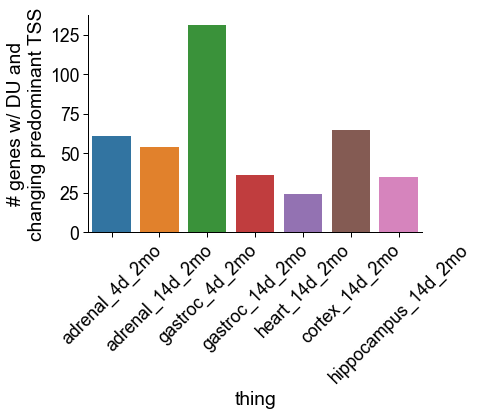

In [98]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
sns.set_context('paper', font_scale=2)

ax = sns.barplot(df4, y='n_du_tss', x='thing')
ax.tick_params(axis="x", rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
_ = ax.set(ylabel='# genes w/ DU and\nchanging predominant TSS')

321


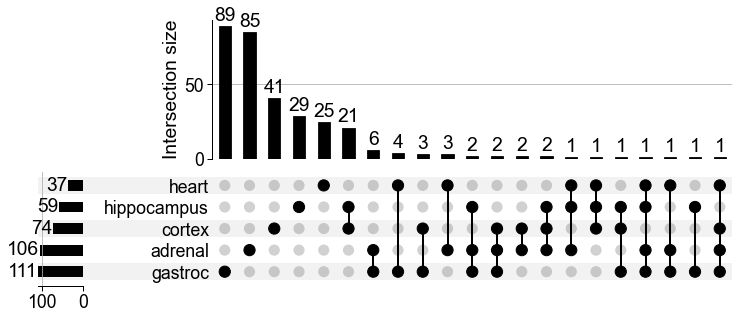

In [105]:
# get upsetplot of all genes from above plot for the 14d guys
temp = g_df.loc[g_df.time1=='14d']
print(len(temp.gid.unique()))
temp.drop(['time1', 'time2'], axis=1, inplace=True)
temp = temp.groupby('gid').agg(','.join).reset_index()
temp.loc[temp.tissue.str.contains(',')]
# temp.pivot(columns='tissue', index='gid') 
temp.head()
beep = upsetplot.from_memberships(temp.tissue.str.split(','), data=temp)
# beep.loc[beep.gid.duplicated()]
p = upsetplot.plot(beep, sort_by='cardinality', show_counts='%d')

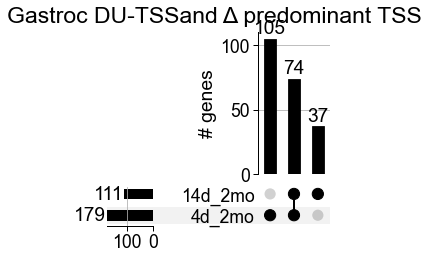

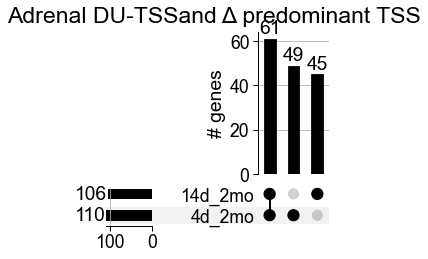

In [107]:
# how mush overlap is there between the 4d and 14d stuff
tissues = ['gastroc', 'adrenal']
for t in tissues:
    temp = g_df.loc[g_df.tissue==t]
    temp['time_comp'] = temp.time1+'_'+temp.time2
    temp.drop(['tissue', 'time1', 'time2'], axis=1, inplace=True)
    temp = temp.groupby('gid').agg(','.join).reset_index()

    beep = upsetplot.from_memberships(temp.time_comp.str.split(','), data=temp)
    p = upsetplot.plot(beep, show_counts='%d', sort_by='cardinality')
    title = u'DU-TSSand Δ predominant TSS'
    title = t.capitalize()+' '+title
    plt.suptitle(title)
    p['intersections'].set_ylabel('# genes')


## looking at things

In [11]:
ca = cerberus.read(m_cerberus_h5)

In [14]:
ca.triplets.loc[ca.triplets.gname=='Aldoa']

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm
7965,vM25,ENSMUSG00000030695,6.0,4.0,12.0,12.0,2.400000,0.483871,0.322581,0.193548,mixed,Aldoa,NaN,NaN
51644,vM25,ENSMUSG00000114515,1.0,1.0,2.0,2.0,2.000000,0.250000,0.250000,0.500000,mixed,Aldoa,NaN,NaN
62954,lapa,ENSMUSG00000030695,4.0,3.0,31.0,39.0,8.857143,0.252252,0.189189,0.558559,splicing,Aldoa,NaN,NaN
90600,vM21,ENSMUSG00000030695,6.0,4.0,12.0,12.0,2.400000,0.483871,0.322581,0.193548,mixed,Aldoa,NaN,NaN
134670,vM21,ENSMUSG00000114515,1.0,1.0,2.0,2.0,2.000000,0.250000,0.250000,0.500000,mixed,Aldoa,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394477,sample_major,ENSMUSG00000030695,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,Aldoa,cortex_18-20mo,3118.457764
409167,sample_major,ENSMUSG00000030695,2.0,1.0,2.0,2.0,1.333333,0.461538,0.230769,0.307692,mixed,Aldoa,c2c12_myotube,3002.706543
421826,sample_major,ENSMUSG00000030695,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,Aldoa,adrenal_10d,2755.041260
436686,sample_major,ENSMUSG00000030695,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,Aldoa,forelimb_e13,575.816589


In [19]:
temp = ca.tss.loc[ca.tss.gene_id=='ENSMUSG00000030695']
pr.PyRanges(temp).to_bed('aldoa_tss.bed')

In [17]:
ca.tss.loc[ca.tss.gene_id=='ENSMUSG00000114515']

,Chromosome,Start,End,Strand,Name,source,novelty,gene_id,tss
48322,chr7,126809057,126809158,-,ENSMUSG00000114515_1,"vM25,vM21,fantom_cage,pls,pol2",Known,ENSMUSG00000114515,1


# look at timecourse DIE results

In [22]:
files = glob.glob('../../proc_revisions/data/mouse/lr/du/*du*tsv')

# filter
p = 0.01
dpi = 10

df = pd.DataFrame()
for f in files:
    tissue = f.rsplit('/', maxsplit=1)[1].split('_', maxsplit=1)[0]
    timept = f.rsplit('/', maxsplit=1)[1].split('_vs_', maxsplit=1)[0].split('_', maxsplit=1)[1]
    timept2 = f.rsplit('/', maxsplit=1)[1].split(tissue, maxsplit=2)[2].split('_', maxsplit=2)[1]
    feat = f.rsplit('_', maxsplit=1)[1].rsplit('.tsv', maxsplit=1)[0]
    
    def make_add_temp(f, df, rev=False):
        temp = pd.read_csv(f, sep='\t')
        temp['tissue'] = tissue
        if not rev:
            temp['time1'] = timept
            temp['time2'] = timept2    
        else:
            temp['time1'] = timept2
            temp['time2'] = timept    
        temp['feat'] = feat
        temp['fname'] = f
        df = pd.concat([temp, df], axis=0)            
        return df
    df = make_add_temp(f, df)
    df = make_add_temp(f, df, rev=True)
    df = df.loc[(df.dpi.abs()>=dpi)&(df.adj_p_val<=p)]
    

In [23]:
# list(set(df.time1.tolist())&set(df.time2.tolist()))
# order = ['4d', '10d', '14d', '25d', '36d', '2mo', '18-20mo']
# cat = pd.CategoricalDtype(categories=order, ordered=True)
# df['time1'] = df['time1'].astype(cat)
# df['time2'] = df['time2'].astype(cat)

In [24]:
df.loc[df.time2.isnull()]['fname'].unique().tolist()

[]

In [25]:
df.loc[df.time1.isnull()]['fname'].unique().tolist()

[]

In [26]:
# # limit just to isos for now
# df = df.loc[df.feat=='iso']

In [27]:
# filter
p = 0.01
dpi = 10
print(len(df.index))
df = df.loc[(df.dpi.abs()>=dpi)&(df.adj_p_val<=p)]
print(len(df.index))

106574
106574


In [28]:
df.to_csv('filt_tc_du.tsv', sep='\t')

In [136]:
# df.loc[df.tissue=='gastroc'][['time1', 'time2']].drop_duplicates()

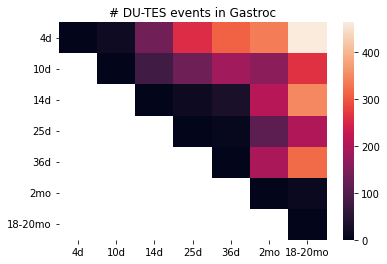

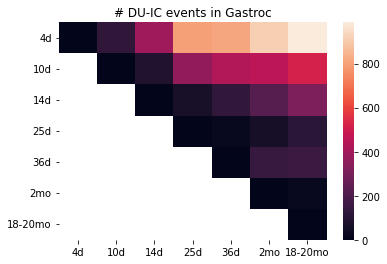

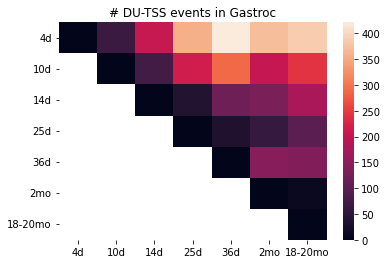

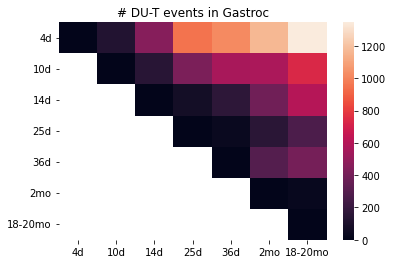

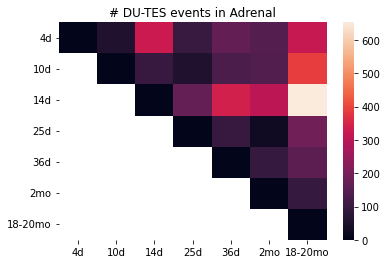

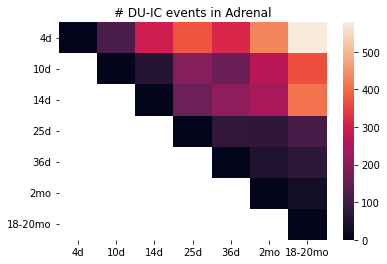

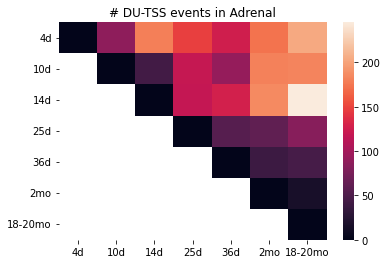

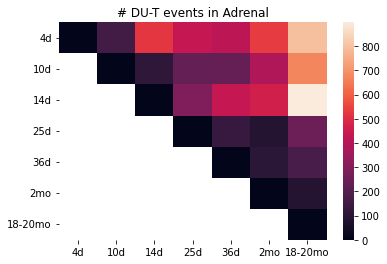

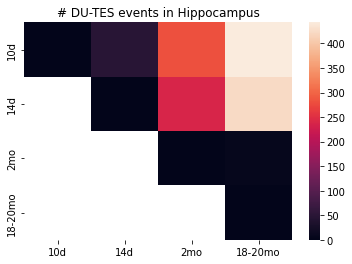

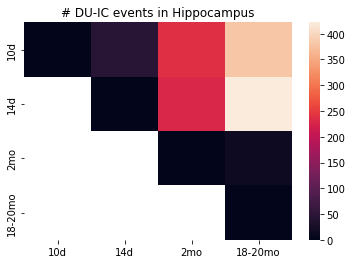

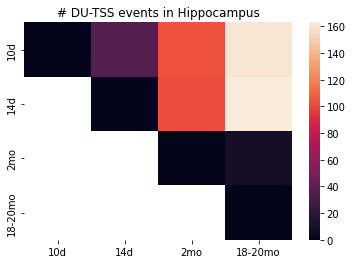

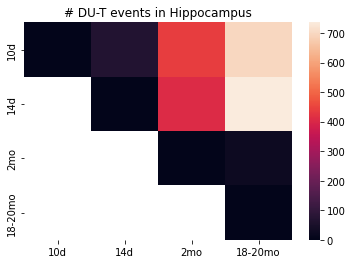

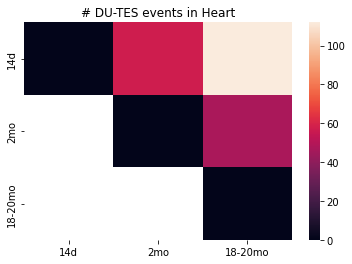

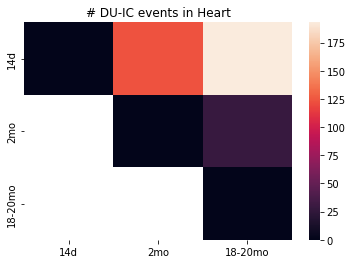

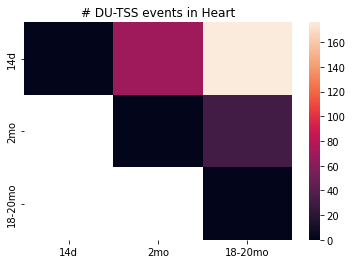

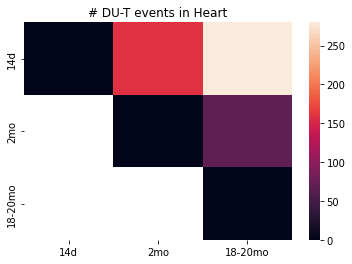

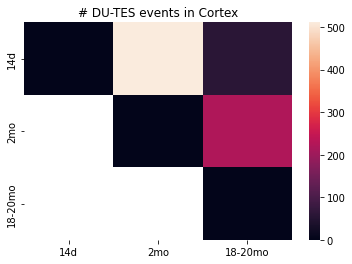

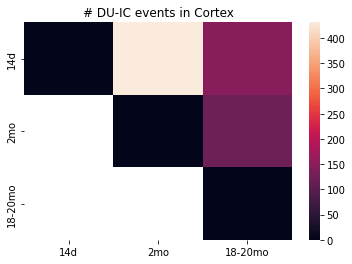

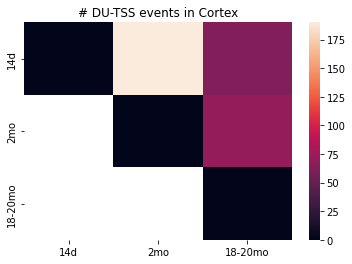

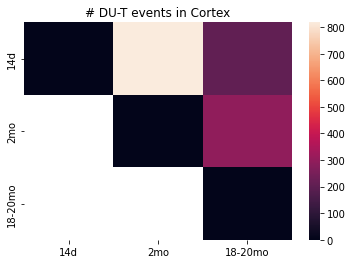

<Figure size 432x288 with 0 Axes>

In [11]:
# get the number of switching events for each thing
for tissue in df.tissue.unique().tolist():
    for feat in df.feat.unique().tolist():
        temp = df.loc[(df.tissue==tissue)&\
                      (df.feat==feat)]
        order = ['4d', '10d', '14d', '25d', '36d', '2mo', '18-20mo']
        order = [c for c in order if c in temp.time1.tolist()+temp.time2.tolist()]
        cat = pd.CategoricalDtype(categories=order, ordered=True)
        temp['time1'] = temp['time1'].astype(cat)
        temp['time2'] = temp['time2'].astype(cat)
        temp2 = temp[['time1', 'time2', 'gid']].groupby(['time1', 'time2'], observed=False).count().reset_index()
        temp2 = temp2.pivot(index='time1', columns='time2')
        temp2.columns = temp2.columns.droplevel(level=0)    
        
        mask = np.tril(temp2)
        ax = sns.heatmap(temp2, mask=mask)
        
        if feat == 'iso':
            feat_label = 'T'
        else:
            feat_label = feat.upper()
        ax.set(ylabel='', xlabel='', title=f'# DU-{feat_label} events in {tissue.capitalize()}')
        plt.show()
        fname = f'figures/n_du_heatmap_{feat}_{tissue}.pdf'
        plt.savefig(fname, dpi=500)
        plt.clf()

In [16]:
# DU-T in corex
temp = df.loc[(df.feat=='iso')&\
              (df.tissue=='cortex')]
temp.head()

,Unnamed: 0,gid,p_val,dpi,pos_iso_1,pos_iso_2,pos_iso_1_dpi,pos_iso_2_dpi,neg_iso_1,neg_iso_2,neg_iso_1_dpi,neg_iso_2_dpi,adj_p_val,gname,tissue,time1,time2,feat,fname
24,24,ENSMUSG00000025920,5.692659e-08,19.040332,"ENSMUSG00000025920[1,4,1]","ENSMUSG00000025920[1,1,1]",9.643312,4.921989,"ENSMUSG00000025920[1,3,3]","ENSMUSG00000025920[1,5,3]",-14.209599,-4.830733,1.591217e-06,Stau2,cortex,2mo,14d,iso,../../proc_revisions/data/mouse/lr/du/cortex_1...
30,30,ENSMUSG00000025931,1.565806e-04,24.105629,"ENSMUSG00000025931[1,1,4]","ENSMUSG00000025931[1,6,5]",18.300949,5.535626,"ENSMUSG00000025931[1,1,2]","ENSMUSG00000025931[1,1,3]",-15.092177,-9.013453,1.943931e-03,Paqr8,cortex,2mo,14d,iso,../../proc_revisions/data/mouse/lr/du/cortex_1...
32,32,ENSMUSG00000026158,6.026570e-06,11.476848,"ENSMUSG00000026158[1,1,2]","ENSMUSG00000026158[1,1,7]",8.889259,1.318485,"ENSMUSG00000026158[1,1,1]","ENSMUSG00000026158[1,5,1]",-8.594835,-2.882013,1.082001e-04,Ogfrl1,cortex,2mo,14d,iso,../../proc_revisions/data/mouse/lr/du/cortex_1...
36,36,ENSMUSG00000073725,8.278251e-09,15.504169,"ENSMUSG00000073725[1,1,7]","ENSMUSG00000073725[1,10,7]",13.009205,2.494964,"ENSMUSG00000073725[1,1,3]","ENSMUSG00000073725[1,1,1]",-8.038863,-2.325699,2.692883e-07,Lmbrd1,cortex,2mo,14d,iso,../../proc_revisions/data/mouse/lr/du/cortex_1...
51,51,ENSMUSG00000045216,1.203394e-07,24.005287,"ENSMUSG00000045216[3,2,1]","ENSMUSG00000045216[2,2,2]",13.559322,7.056137,"ENSMUSG00000045216[1,1,1]",NaN,-24.005287,NaN,3.164757e-06,Hs6st1,cortex,2mo,14d,iso,../../proc_revisions/data/mouse/lr/du/cortex_1...


In [17]:
temp.loc[temp.gname=='Gria2']

,Unnamed: 0,gid,p_val,dpi,pos_iso_1,pos_iso_2,pos_iso_1_dpi,pos_iso_2_dpi,neg_iso_1,neg_iso_2,neg_iso_1_dpi,neg_iso_2_dpi,adj_p_val,gname,tissue,time1,time2,feat,fname
1438,1438,ENSMUSG00000033981,1.919912e-17,15.111123,"ENSMUSG00000033981[1,2,2]","ENSMUSG00000033981[1,2,3]",11.265692,3.845431,"ENSMUSG00000033981[1,2,12]","ENSMUSG00000033981[1,1,12]",-7.363565,-7.015085,1.847866e-15,Gria2,cortex,2mo,14d,iso,../../proc_revisions/data/mouse/lr/du/cortex_1...
1438,1438,ENSMUSG00000033981,1.919912e-17,15.111123,"ENSMUSG00000033981[1,2,2]","ENSMUSG00000033981[1,2,3]",11.265692,3.845431,"ENSMUSG00000033981[1,2,12]","ENSMUSG00000033981[1,1,12]",-7.363565,-7.015085,1.847866e-15,Gria2,cortex,14d,2mo,iso,../../proc_revisions/data/mouse/lr/du/cortex_1...
1460,1460,ENSMUSG00000033981,3.804127e-07,12.560241,"ENSMUSG00000033981[1,2,2]","ENSMUSG00000033981[1,2,3]",9.942516,2.617725,"ENSMUSG00000033981[1,2,12]","ENSMUSG00000033981[1,1,12]",-5.835447,-5.172546,3.353620e-05,Gria2,cortex,18-20mo,14d,iso,../../proc_revisions/data/mouse/lr/du/cortex_1...
1460,1460,ENSMUSG00000033981,3.804127e-07,12.560241,"ENSMUSG00000033981[1,2,2]","ENSMUSG00000033981[1,2,3]",9.942516,2.617725,"ENSMUSG00000033981[1,2,12]","ENSMUSG00000033981[1,1,12]",-5.835447,-5.172546,3.353620e-05,Gria2,cortex,14d,18-20mo,iso,../../proc_revisions/data/mouse/lr/du/cortex_1...


In [137]:
# DU-IC in corex
temp = df.loc[(df.feat=='ic')&\
              (df.tissue=='cortex')]
temp.head()

,Unnamed: 0,gid,p_val,dpi,pos_iso_1,pos_iso_2,pos_iso_1_dpi,pos_iso_2_dpi,neg_iso_1,neg_iso_2,neg_iso_1_dpi,neg_iso_2_dpi,adj_p_val,gname,tissue,time1,time2,feat,fname
89,89,ENSMUSG00000001089,1.015970e-04,28.428964,ENSMUSG00000001089_4,ENSMUSG00000001089_9,13.756831,8.169399,ENSMUSG00000001089_1,ENSMUSG00000001089_2,-16.693990,-11.734974,5.994224e-03,Luzp1,cortex,2mo,18-20mo,ic,../../proc_revisions/data/mouse/lr/du/cortex_1...
195,195,ENSMUSG00000002052,2.441175e-07,25.556616,ENSMUSG00000002052_3,NaN,25.556616,NaN,ENSMUSG00000002052_1,NaN,-25.556610,NaN,3.113575e-05,Supt6,cortex,2mo,18-20mo,ic,../../proc_revisions/data/mouse/lr/du/cortex_1...
250,250,ENSMUSG00000002625,7.166751e-11,20.935278,NaN,NaN,16.323660,4.611618,NaN,NaN,-7.976919,-6.567979,1.942414e-08,Akap8l,cortex,2mo,18-20mo,ic,../../proc_revisions/data/mouse/lr/du/cortex_1...
258,258,ENSMUSG00000002748,2.972069e-10,50.264552,ENSMUSG00000002748_2,NaN,50.264552,NaN,ENSMUSG00000002748_1,ENSMUSG00000002748_9,-49.055172,-1.020408,7.581399e-08,Baz1b,cortex,2mo,18-20mo,ic,../../proc_revisions/data/mouse/lr/du/cortex_1...
279,279,ENSMUSG00000002949,9.787948e-05,26.255493,ENSMUSG00000002949_1,NaN,26.255493,NaN,ENSMUSG00000002949_11,ENSMUSG00000002949_7,-8.909279,-8.567241,5.854543e-03,Timm44,cortex,2mo,18-20mo,ic,../../proc_revisions/data/mouse/lr/du/cortex_1...


In [141]:
temp.sort_values(by='dpi', ascending=False).head(20).tail(10)[['gname', 'dpi', 'adj_p_val', 'pos_iso_1', 'neg_iso_1', 'feat']]

,gname,dpi,adj_p_val,pos_iso_1,neg_iso_1,feat
7365,Aak1,77.358490,2.185089e-14,ENSMUSG00000057230_3,ENSMUSG00000057230_2,ic
7365,Aak1,77.358490,2.185089e-14,ENSMUSG00000057230_3,ENSMUSG00000057230_2,ic
6085,Dnm3,76.993046,5.038267e-09,ENSMUSG00000040265_14,ENSMUSG00000040265_13,ic
6085,Dnm3,76.993046,5.038267e-09,ENSMUSG00000040265_14,ENSMUSG00000040265_13,ic
7476,Aak1,74.233490,2.883725e-07,ENSMUSG00000057230_3,ENSMUSG00000057230_2,ic
7476,Aak1,74.233490,2.883725e-07,ENSMUSG00000057230_3,ENSMUSG00000057230_2,ic
7197,Gon4l,73.684212,7.081561e-03,ENSMUSG00000054199_11,ENSMUSG00000054199_7,ic
7197,Gon4l,73.684212,7.081561e-03,ENSMUSG00000054199_11,ENSMUSG00000054199_7,ic
7041,Usp29,71.904767,6.005886e-04,ENSMUSG00000051527_8,ENSMUSG00000051527_9,ic
7041,Usp29,71.904767,6.005886e-04,ENSMUSG00000051527_8,ENSMUSG00000051527_9,ic


## Some line plots

In [111]:
# if feat == 'ic':
pi_df = swan.calc_pi(sg.ic_adata, sg.ic_adata.var, obs_col='dataset')
pi_df = pi_df[0].sparse.to_dense()

In [126]:
def make_pi_line_plot(pi_df, gene, tissue, feat, feat_ids=None):
    gid = sg.t_df.loc[sg.t_df.gname==gene, 'gid'].values[0]
    
    if feat_ids:
        ids = [f'{gid}_{f}' for f in feat_ids]
    
    temp = pi_df.copy(deep=True)
    temp = temp[[c for c in temp.columns if gid in c]]
    temp.fillna(0, inplace=True)
    temp = temp.melt(ignore_index=False, var_name=feat, value_name='pi')
    temp = temp.merge(sg.adata.obs[['age', 'tissue']], left_index=True, right_index=True)
    temp = temp.loc[temp.tissue==tissue]
    
    if feat_ids:
        temp = temp.loc[temp[feat].isin(ids)]
    
    order = ['4d', '10d', '14d', '25d', '36d', '2mo', '18-20mo']
    order = [c for c in order if c in temp.age.tolist()]
    cat = pd.CategoricalDtype(categories=order, ordered=True)
    temp['age'] = temp['age'].astype(cat)
    
    sns.set_context('paper', font_scale=2)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    
    ax = sns.lineplot(data=temp, x='age', y='pi', hue=feat)    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set(title=f'{gene} in {tissue}')
    plt.legend(bbox_to_anchor=(.6, 1.05))    


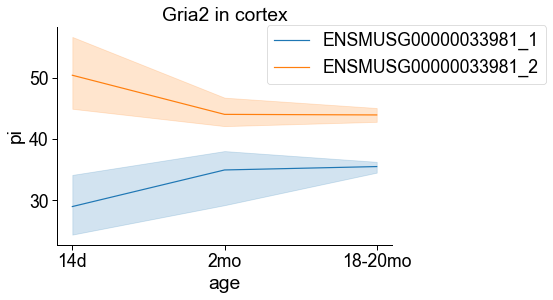

In [127]:
gene = 'Gria2'
tissue = 'cortex'
feat = 'ic'
feat_ids = [1, 2]
make_pi_line_plot(pi_df, gene, tissue, feat, feat_ids=feat_ids)

In [107]:
temp

,ic,pi,age,tissue
cortex_14d_f_1,ENSMUSG00000033981_1,36.666668,14d,cortex
cortex_14d_f_1,ENSMUSG00000033981_2,43.333332,14d,cortex
cortex_14d_f_2,ENSMUSG00000033981_1,26.589596,14d,cortex
cortex_14d_f_2,ENSMUSG00000033981_2,49.710983,14d,cortex
cortex_14d_m_1,ENSMUSG00000033981_1,30.188679,14d,cortex
cortex_14d_m_1,ENSMUSG00000033981_2,49.528301,14d,cortex
cortex_14d_m_2,ENSMUSG00000033981_1,22.522522,14d,cortex
cortex_14d_m_2,ENSMUSG00000033981_2,59.009010,14d,cortex
cortex_18-20mo_f_1,ENSMUSG00000033981_1,35.766422,18-20mo,cortex
cortex_18-20mo_f_1,ENSMUSG00000033981_2,43.065693,18-20mo,cortex


<AxesSubplot:xlabel='age', ylabel='pi'>

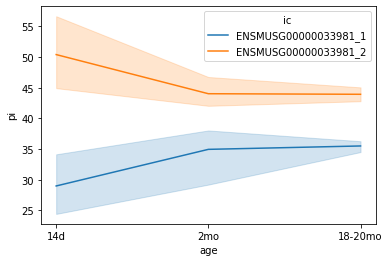

## swan

In [42]:
def get_flagship_timepoint_colors():
    c_dict = {
    '4d': '#fcfdff',
    '10d': '#e8f0fa',
    '14d': '#d3e3f2',
    '25d': '#accfe6',
    '36d': '#75b2dc',
    '2mo': '#4693c8',
    '18-20mo': '#164894'}
    order = ['4d', '10d', '14d', '25d', '36d', '2mo', '18-20mo']
    return c_dict, order

def get_flagship_tissue_colors():
    c_dict  = {
    'adrenal': '#ff9458',
    'cortex': '#ffe578',
    'hippocampus': '#967add',
    'gastroc': '#34b0d8',
    'heart': '#ff9aaf'}
    order = ['adrenal', 'cortex', 'hippocampus', 'gastroc', 'heart']
    return c_dict, order

In [21]:
sg = swan.read(m_swan_file)

Read in graph from ../../proc_revisions/data/mouse/lr/swan/swan_graph.p


In [31]:
# limit to the timecourse
inds = sg.adata.obs[sg.adata.obs.genotype=='b6/cast'].index
sg.adata = sg.adata[inds, :]
sg.adata

View of AnnData object with n_obs × n_vars = 92 × 152164
    obs: 'dataset', 'total_counts', 'ENCODE_experiment_id', 'sample', 'sample_display', 'general_tissue_cell_type', 'fig1_tissue_label', 'age', 'sex', 'genotype', 'tissue_or_cell_line', 'sample_color_hex_code', 'matching_human_samples', 'reads_post_talon', 'ENCODE_alignments_id', 'ENCODE_reads_id', 'ENCODE_unfiltered_alignments_id', 'document_urls', 'document_labels', 'platform', 'RIN', 'spikeins'
    var: 'tid'
    uns: 'sample_colors', 'sample_dict'
    layers: 'counts', 'tpm', 'pi'

In [32]:
c_dict, order = get_flagship_timepoint_colors()
sg.set_metadata_colors('age', c_dict)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/swan_vis/swangraph.py:2436: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.adata.obs[obs_col] = self.adata.obs[obs_col].astype('category')


In [40]:
sg.adata.obs['tissue'] = sg.adata.obs['sample'].str.split('_', expand=True)[0]

In [43]:
c_dict, order = get_flagship_tissue_colors()
sg.set_metadata_colors('tissue', c_dict)

In [ ]:
g = 'Clu'
sg.gen_report(g,
              f'figures/{g}',
              novelty=True,
              cmap='viridis',
              indicate_novel=True,
              transcript_col='tname',
              metadata_cols=['genotype', 'sex', 'tissue', 'age'],
              datasets={'genotype': sg.adata.obs.genotype.unique().tolist()})
sg.gen_report(g,
              f'figures/{g}',
              novelty=True,
              cmap='magma',
              transcript_col='tname',
              display_numbers=True,
              browser=True,
              layer='pi',
              metadata_cols=['genotype', 'sex', 'tissue', 'age'],
              datasets={'genotype': sg.adata.obs.genotype.unique().tolist()})

## older

In [38]:
# sg = swan.read(m_swan_file)

In [35]:
# def get_tc_mouse_samples(config):
#     m_lib_meta = expand(config['lr']['meta'], species='mouse')[0]
#     df = pd.read_csv(m_lib_meta, sep='\t')
#     tc_tissues = ['muscle', 'hippocampus', 'cortex', 'adrenal gland', 'heart']
#     tc_times = ['18-20mo', '2mo', '4d', '25d', '14d', '36d', '10d']
#     meta.head()
#     s = meta.loc[(meta.general_tissue_cell_type.isin(tc_tissues))&\
#              (meta.age.isin(tc_times)), 'sample'].unique().tolist()
#     return s

# def get_du_tc_cfg_entries():
#     """
#     Get the cfg entries for running du tests
#     """
#     obs_col = 'sample'
#     feats = ['tss', 'tes', 'ic', 'iso']
#     combos = [c for c in itertools.combinations(s, 2) if c[0].split('_')[0]==c[1].split('_')[0]]
#     obs_cond1 = [c[0] for c in combos]
#     obs_cond2 = [c[1] for c in combos]
#     files = expand(expand(config['lr']['analysis']['du'],
#                   zip,
#                   obs_cond1=obs_cond1,
#                   obs_cond2=obs_cond2,
#                   allow_missing=True),
#                   obs_col='sample',
#                   species='mouse',
#                   feat=feats)
#     return files

In [34]:
# get_du_tc_cfg_entries()

In [36]:
# def get_tc_mouse_samples():
#     m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
#     df = pd.read_csv(m_lib_meta, sep='\t')
#     tc_tissues = ['muscle', 'hippocampus', 'cortex', 'adrenal gland', 'heart']
#     tc_times = ['18-20mo', '2mo', '4d', '25d', '14d', '36d', '10d']
#     meta.head()
#     s = meta.loc[(meta.general_tissue_cell_type.isin(tc_tissues))&\
#              (meta.age.isin(tc_times)), 'sample'].unique().tolist()
#     return s

# # meta = sg.adata.obs.copy(deep=True)
# # meta.head()
# # tc_tissues = ['muscle', 'hippocampus', 'cortex', 'adrenal gland', 'heart']
# # tc_times = ['18-20mo', '2mo', '4d', '25d', '14d', '36d', '10d']
# # meta.head()
# # s = meta.loc[(meta.general_tissue_cell_type.isin(tc_tissues))&\
# #          (meta.age.isin(tc_times))]
# s = get_tc_mouse_samples()
# print(s)
    

In [37]:
# combos = [c for c in itertools.combinations(s, 2) if c[0].split('_')[0]==c[1].split('_')[0]]
# combos
# # obs_cond1 = [c[0] for c in combos]
# # obs_cond2 = [c[1] for c in combos]

In [ ]:
tp_palette = c('PND_04' = '#fcfdff',
                'PND_10' = '#e8f0fa',
                'PND_14' = '#d3e3f2',
                'PND_25' = '#accfe6',
                'PND_36' = '#75b2dc',
                'PNM_02' = '#4693c8',
                'PNM_08-14' = '#246db2',
                'PNM_18' = '#164894')